# Using FEM to solve scattering problem

## Problem description

$$
\begin{aligned}
&\Delta u + k(x)^2 u = 0 &\text{for } x \in \Gamma \\
&(\nabla-ik_0)(u-u_0) = 0           &\text{for } x \in \partial \Gamma
\end{aligned}
$$

where $\Gamma$ is a spherical domain and $k=k_0$ at $\partial\Gamma$

## Step 1. Setup geometry

In [1]:
from geom import ball, box
geom = ball(2,.2) - ball(.5, .2)
geom.eps = .1

## Step 2. Setup mesh

N	avr
4534	-0.040226054046661415
step	substep	max dis
9	80	0.20753760246846047


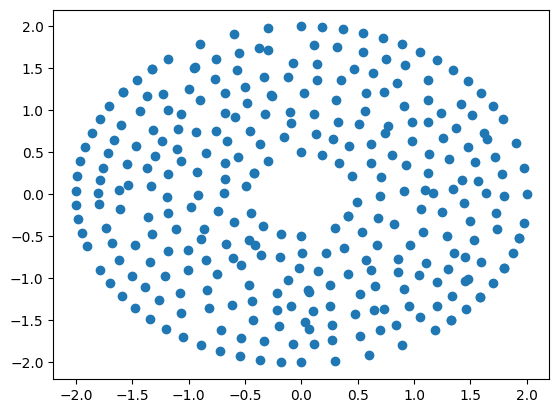

In [2]:
from mesh import Mesh
mesh = Mesh(3000, .3, geom)
mesh.refine(.01,N_tot=10,N_sub=100)
import matplotlib.pyplot as plt
import numpy as np
points = mesh.points[list(set(mesh.get_simplices().ravel()))]
plt.scatter(*points[abs(points[:,1])<.1][:,[0,2]].T)

## Step 3. Setup FEM matrices

In [3]:
from FEM import FEM
fem = FEM(mesh)

## Step 4. Setup source, boundary and everything else

In [4]:
from numpy.linalg import norm
from numpy import exp
n = norm(mesh.points, axis=-1)
k = 4
k2 = (exp(-n**2)+1) * k**2
x = mesh.points[:,0]
cos = mesh.points[:,0] / n
src = 1j * k * (x/n-1) * exp(1j*x*k)
b = fem.bound @ src
L = fem.nabla - fem.diag(k2) - 1j*k*fem.bound

## Step 5. Solve with BICGSTAB

In [5]:
from scipy.sparse.linalg import bicgstab
u,conv = bicgstab(L,b)
print(f"conv={conv}")

conv=0


## Final Step: Visualize

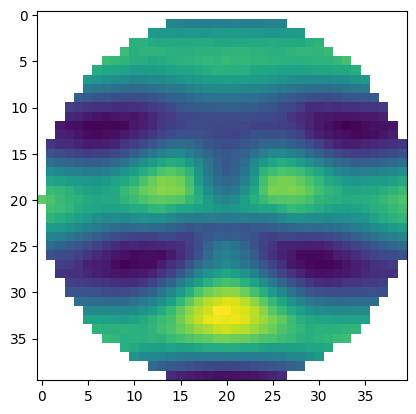

In [6]:
from scipy.interpolate import LinearNDInterpolator
from numpy import mgrid
u = LinearNDInterpolator(mesh.tri, u)
x,y = mgrid[-2:2:.1,-2:2:.1]
plt.imshow(u(x,y,0).real)